In [1]:
from cpmpy import *
## torch for training neural network
import pytorch_lightning as pl
import torch.nn.functional as F
import torch
from torch import nn, optim
import torch.utils.data as data_utils
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
## logger module
from pytorch_lightning import loggers as pl_loggers
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
## sklean module for data transforming and model running
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
import sklearn
#module to create plot
import seaborn as sns
import matplotlib.pyplot as plt
# useful modules
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
import os
import shutil

### First we write a knapsack solver using CPMpy

In [2]:
class problem_solver:
    def __init__(self,weights,capacity,n_items):
        self.weights = weights
        self.capacity =  capacity
        self.n_items = n_items
        self.x = boolvar(shape=n_items, name="x")
        self.model = Model(sum(self.x*weights[0]) <= capacity)
        
    def solve_knapsack(self,cost):
        cost_ = (1000*cost).astype(int)
        # We have to convert the cost variable into integer, as ORtools only accepts integer variable
        self.model.maximize((self.x*cost_).sum())
        self.model.solve()
        return self.x.value()
        
        
    def solve_from_pytorch(self,cost_inpytorch):
        # cost_inpytorch is a pytorch tensor object
        cost_ = cost_inpytorch.detach().numpy()
        x = self.solve_knapsack(cost_)
        return torch.from_numpy(x).float()
    

#### Let us use it to solve a simple knapsack problem.

In [3]:
knapsack_solver = problem_solver(weights = [[1,2,3,1]], capacity=3,n_items=4)
knapsack_solver.solve_knapsack(np.array([10,20,25,15]))

array([0, 1, 0, 1])

#### In this example, out of the 4 objects, the 2nd and the 4th one are selcted.

### Next we are going to seed for reproducibility

In [5]:
def seed_all(seed):
    print("[ Using Seed : ", seed, " ]")

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    

seed = 10
seed_all(seed)

[ Using Seed :  10  ]


#### Now we  load the data.

In [176]:
if not os.path.exists('Data.npz'):
    torch.hub.download_url_to_file("https://github.com/JayMan91/aaai_predit_then_optimize/raw/master/Data.npz", "Data.npz")
data = np.load("Data.npz")
x_train,  x_test, y_train,y_test = data['X_1gtrain'],data['X_1gtest'],data['y_train'],data['y_test']
x_train = x_train[:,1:]
x_test = x_test[:,1:]
print(x_train.shape)

(26496, 8)


In [69]:
#### standardize the feature variables
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

#### 8 features: HolidayFlag, DayOfWeek, WeekOfYear, Month, ForecastWindProduction, Forecasted SystemLoad,  Forecasted Energy price, Forecasted CO2Intensity
#### And the predictor variable: Energy Price

In [70]:
#### We also reshape the data in groups of 48 so that each group is an instance.
x_train = x_train.reshape(-1,48,x_train.shape[1])
y_train = y_train.reshape(-1,48)
x_test = x_test.reshape(-1,48,x_test.shape[1])
y_test = y_test.reshape(-1,48)

In [71]:
## we now randomize the training and test data
x = np.concatenate((x_train, x_test), axis=0)
y = np.concatenate((y_train,y_test), axis=0)
x,y = sklearn.utils.shuffle(x,y,random_state = seed)
x_train, y_train = x[0:550], y[0:550]
x_valid, y_valid = x[550:600], y[550:600]
x_test, y_test = x[600:], y[600:]

In [72]:

print("Number of instances in training {} and testing {}".format(x_train.shape, x_test.shape))


Number of instances in training (550, 48, 8) and testing (189, 48, 8)


#### As we see, we have 550 training instances and test on 189 instances.

### We will use this data in the context of knapsack problem. The predicted  Energy Price forms the value of knapsack. In our setup, each knapsack instance consists of 48 items. 

In [73]:
weights = [data['weights'].tolist()]
weights = np.array(weights)
n_items = 48
capacity = 120
print(np.sum(weights))

240


#### The weights are the costs of each item. The weights are kept same for each instance. The summation of 48 weights are 240. The knapsack capacity in this example is 60

#### Next, we create a solver instance with the specified weights and capacity

In [74]:
knapsack_solver = problem_solver(weights,capacity,n_items)

### The desirable goal to minimze the regret,
### Regret is the loss in the objective value for using the solution of predicted value rather than the solution of true value (which we do not know).


### If $c$ are the true values and $\hat{c}$ are the predicted values and $w^\star(c)$ and $w^\star(\hat{c})$ are their solutions. 
### Then regret $=c^\top( w^\star(c) -w^\star(\hat{c}) )$

In [75]:
## A function to compute regret
def regret_score(solver, sol,y, y_pred):
        total_loss =0 
        for i in tqdm_notebook(range(len(y))):
            sol_pred = solver.solve_from_pytorch(y_pred[i])
            total_loss +=  ((sol[i] - sol_pred).dot(y[i]))
        return total_loss/len(y)

#### We will also need a dataloder module, which will segregate the training data into batches

In [76]:
class Datawrapper():
    def __init__(self, X,y):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.float32)

        
        sol = []
        for i in tqdm_notebook(range(len(y))):
            x_sol = knapsack_solver.solve_knapsack(y[i])            
            sol.append( x_sol)
        self.sol = np.array(sol).astype(np.float32)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return  self.X[idx],self.y[idx],self.sol[idx]

In [77]:
train_dl =  DataLoader( Datawrapper(x_train,y_train),batch_size= 32)
valid_dl =   DataLoader( Datawrapper(x_valid,y_valid),batch_size= 50)
test_dl =   DataLoader( Datawrapper(x_test,y_test),batch_size= 50)

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/189 [00:00<?, ?it/s]

## Two-stage MSE Regression Model

In [78]:
class twostage_regression(pl.LightningModule):
    def __init__(self,net,solver = knapsack_solver, lr=1e-1, l1_weight=1e-5,max_epochs=30, seed=seed):
        """
        A class to implement two stage mse based model and with test and validation module
        Args:
            net: the neural network model
            solver: the solver which returns a shortest path solution given the edge cost
            lr: learning rate
            l1_weight: the lasso regularization weight
            max_epoch: maximum number of epcohs
            seed: seed for reproducibility 
        """
        super().__init__()
        pl.seed_everything(seed)
        self.net =  net
        self.lr = lr
        self.l1_weight = l1_weight
        self.solver = solver
        self.max_epochs= max_epochs
        self.save_hyperparameters("lr",'l1_weight')
    def forward(self,x):
        return self.net(x) 
    def training_step(self, batch, batch_idx):
        x,y, sol = batch
        y_hat =  self(x).squeeze()
        criterion = nn.MSELoss(reduction='mean')
        loss = criterion(y_hat,y)
        l1penalty = sum([(param.abs()).sum() for param in self.net.parameters()])
        training_loss =  loss  + l1penalty * self.l1_weight
        self.log("train_totalloss",training_loss, prog_bar=True, on_step=True, on_epoch=True, )
        self.log("train_l1penalty",l1penalty * self.l1_weight,  on_step=True, on_epoch=True, )
        self.log("train_loss",loss,  on_step=True, on_epoch=True, )
        return training_loss 
    def validation_step(self, batch, batch_idx):
        criterion = nn.MSELoss(reduction='mean')
        x,y, sol = batch
        y_hat =  self(x).squeeze()
        mseloss = criterion(y_hat, y)
        regret_loss =  regret_score(self.solver,sol,y, y_hat) 

        self.log("val_mse", mseloss, prog_bar=True, on_step=True, on_epoch=True, )
        self.log("val_regret", regret_loss, prog_bar=True, on_step=True, on_epoch=True, )

        return {"val_mse":mseloss, "val_regret":regret_loss}
    def validation_epoch_end(self, outputs):
        avg_regret = torch.stack([x["val_regret"] for x in outputs]).mean()
        avg_mse = torch.stack([x["val_mse"] for x in outputs]).mean()
        
        self.log("ptl/val_regret", avg_regret)
        self.log("ptl/val_mse", avg_mse)
        # self.log("ptl/val_accuracy", avg_acc)
        
    def test_step(self, batch, batch_idx):
        criterion = nn.MSELoss(reduction='mean')
        x,y, sol = batch
        y_hat =  self(x).squeeze()
        mseloss = criterion(y_hat, y)
        regret_loss =  regret_score(self.solver,sol,y, y_hat) 

        self.log("test_mse", mseloss, prog_bar=True, on_step=True, on_epoch=True, )
        self.log("test_regret", regret_loss, prog_bar=True, on_step=True, on_epoch=True, )

        return {"test_mse":mseloss, "test_regret":regret_loss}
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        num_batches = len(self.train_dataloader()) // self.trainer.accumulate_grad_batches
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = self.lr, epochs=self.max_epochs,
        steps_per_epoch = num_batches)
        return [optimizer], [scheduler]

In [79]:
log_dir = "lightning_logs/Twostage/"
shutil.rmtree(log_dir,ignore_errors=True)

In [80]:
tb_logger = pl_loggers.TensorBoardLogger(save_dir= log_dir, version=0)
trainer = pl.Trainer(max_epochs= 20, min_epochs=5, logger=tb_logger)
mse_model = twostage_regression(net=nn.Linear(8,1), lr= 0.1, max_epochs= 30)
trainer.fit(mse_model, train_dl, valid_dl)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 10

  | Name | Type   | Params
--------------------------------
0 | net  | Linear | 9     
--------------------------------
9         Trainable params
0         Non-trainable params
9         Total params
0.000     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/jayanta/anaconda3/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


  0%|          | 0/50 [00:00<?, ?it/s]

Global seed set to 10
/home/jayanta/anaconda3/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/home/jayanta/anaconda3/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:327: UserWarning: The number of training samples (18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

### Now we examine the learning curve

In [81]:
parent_dir=   log_dir+"default/"
version_dirs = [os.path.join(parent_dir,v) for v in os.listdir(parent_dir)]

walltimes = []
steps = []
regrets= []
mses = []
for logs in version_dirs:
    event_accumulator = EventAccumulator(logs)
    event_accumulator.Reload()

    events = event_accumulator.Scalars("val_regret_epoch")
    walltimes.extend( [x.wall_time for x in events])
    steps.extend([x.step for x in events])
    regrets.extend([x.value for x in events])
    events = event_accumulator.Scalars("val_mse_epoch")
    mses.extend([x.value for x in events])
mse_lr = pd.DataFrame({"step": steps,'wall_time':walltimes,  "val_regret": regrets,
 "val_mse": mses })
mse_lr ['model'] ='mse'

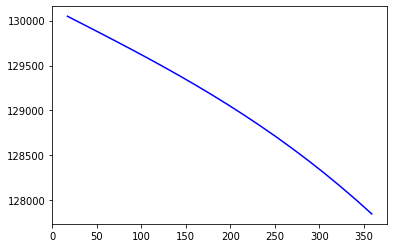

In [82]:
plt.plot(steps,mses,'b')

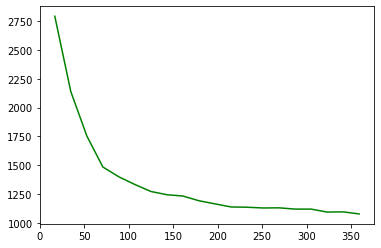

In [83]:
plt.plot(steps,regrets,'g')

In [84]:
mse_result = trainer.test(mse_model, dataloaders=test_dl)
mse_result_df =  pd.DataFrame(mse_result)
mse_result_df['model'] = 'mse'

/home/jayanta/anaconda3/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Testing: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_mse': 145508.640625,
 'test_mse_epoch': 145508.640625,
 'test_regret': 1312.559326171875,
 'test_regret_epoch': 1312.559326171875}
--------------------------------------------------------------------------------


### First we define SPO Loss

In [85]:
def SPOLoss(solver, minimize=False):
    mm = 1 if minimize else -1
    class SPOLoss_cls(torch.autograd.Function):
        @staticmethod
        def forward(ctx, y_pred, y_true, sol_true):
       
            sol_hat = solver.solve_from_pytorch(y_pred)
            sol_spo = solver.solve_from_pytorch(2* y_pred - y_true)
            ctx.save_for_backward(sol_spo,  sol_true, sol_hat)
            return   mm*(  sol_hat - sol_true).dot(y_true)/( sol_true.dot(y_true) ) # changed to per cent rgeret

        @staticmethod
        def backward(ctx, grad_output):
            sol_spo,  sol_true, sol_hat = ctx.saved_tensors
            return mm*(sol_true - sol_spo), None, None
            
    return SPOLoss_cls.apply 

In [86]:
class SPO(twostage_regression):
    def __init__(self,net,solver = knapsack_solver,lr=1e-1, l1_weight=1e-5,max_epochs=30, seed=seed):
        """
        Implementaion of SPO+ loss subclass of twostage model
 
        """
        super().__init__(net,solver, lr, l1_weight,max_epochs, seed)
    def training_step(self, batch, batch_idx):
        x,y,sol = batch
        y_hat =  self(x).squeeze()
        loss = 0
        l1penalty = sum([(param.abs()).sum() for param in self.net.parameters()])
        for ii in range(len(y)):
            loss += SPOLoss(self.solver)(y_hat[ii],y[ii],sol[ii])
        training_loss=  loss/len(y)  + l1penalty * self.l1_weight
        self.log("train_totalloss",training_loss, prog_bar=True, on_step=True, on_epoch=True, )
        self.log("train_l1penalty",l1penalty * self.l1_weight,  on_step=True, on_epoch=True, )
        self.log("train_loss",loss/len(y),  on_step=True, on_epoch=True, )
        return training_loss  

In [87]:
log_dir = "lightning_logs/SPO/"
shutil.rmtree(log_dir,ignore_errors=True)

In [88]:
tb_logger = pl_loggers.TensorBoardLogger(save_dir= log_dir, version=0)
trainer = pl.Trainer(max_epochs= 20, min_epochs=5, logger=tb_logger)
spo_model = SPO(net=nn.Linear(8,1), lr= 0.1, max_epochs= 30)
trainer.fit(spo_model, train_dl, valid_dl)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 10

  | Name | Type   | Params
--------------------------------
0 | net  | Linear | 9     
--------------------------------
9         Trainable params
0         Non-trainable params
9         Total params
0.000     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Global seed set to 10


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [89]:
parent_dir=   log_dir+"default/"
version_dirs = [os.path.join(parent_dir,v) for v in os.listdir(parent_dir)]

walltimes = []
steps = []
regrets= []
mses = []
for logs in version_dirs:
    event_accumulator = EventAccumulator(logs)
    event_accumulator.Reload()

    events = event_accumulator.Scalars("val_regret_epoch")
    walltimes.extend( [x.wall_time for x in events])
    steps.extend([x.step for x in events])
    regrets.extend([x.value for x in events])
    events = event_accumulator.Scalars("val_mse_epoch")
    mses.extend([x.value for x in events])
spo_lr = pd.DataFrame({"step": steps,'wall_time':walltimes,  "val_regret": regrets,
 "val_mse": mses })
spo_lr ['model'] ='SPO'

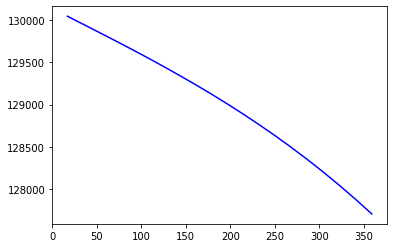

In [90]:
plt.plot(steps,mses,'b')

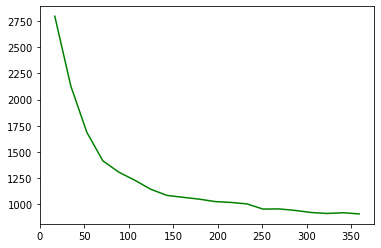

In [91]:
plt.plot(steps,regrets,'g')

In [92]:
spo_result = trainer.test(spo_model, dataloaders=test_dl)
spo_result_df = pd.DataFrame(spo_result)
spo_result_df ['model'] = 'SPO'

Testing: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_mse': 145436.609375,
 'test_mse_epoch': 145436.609375,
 'test_regret': 1267.338134765625,
 'test_regret_epoch': 1267.338134765625}
--------------------------------------------------------------------------------


In [93]:
def Listnet_KLloss(y_hat,y_true,cache,tau=1,minimize=False,*wd,**kwd):
    mm = 1 if minimize else -1 
    loss = 0
#     print("cache shape",  cache.shape, "y_pr shape", y_hat.shape, "y_true shape", y_true.shape)
    for ii in range(len(y_true)):

        first_term  = (F.log_softmax((-mm*y_true[ii]*cache/tau).sum(dim=1),dim=0) -
         F.log_softmax((-mm*y_hat[ii]*cache/tau).sum(dim=1),dim=0))
#         first_term  =  -F.log_softmax((-mm*y_hat[ii]*cache/tau).sum(dim=1),dim=0)
        second_term = F.softmax((-mm*y_true[ii]*cache/tau).sum(dim=1),dim=0)
        loss += ( first_term * second_term).mean()
    return loss/len(y_true)

In [94]:
def pairwise_loss(y_hat,y_true,cache,tau=0, minimize= False,mode= 'W'):
    '''
    sol, y and y_hat are torch array [batch_size,48]
    cache is torch array [currentpoolsize,48]
    '''
    mm = 1 if minimize else -1 
    loss = 0
    relu = nn.ReLU()
    for ii in range(len(y_true)):
        _,indices= np.unique((mm*y_true[ii]*cache).sum(dim=1).detach().numpy(),return_index=True)
        ## return indices after sorting the array in ascending order
        if mode == 'B':
            big_ind = [indices[0] for p in range(len(indices)-1)] #good one
            small_ind = [indices[p+1] for p in range(len(indices)-1)] #bad one
        if mode == 'W':
            big_ind = [indices[p] for p in range(len(indices)-1)] #good one
            small_ind = [indices[-1] for p in range(len(indices)-1)] #bad one
        if mode == 'S':
            big_ind = [indices[p] for p in range(len(indices)-1)] #good one
            small_ind = [indices[p+1] for p in range(len(indices)-1)] #bad one


        loss += relu(tau+ mm*( torch.matmul(cache[big_ind], y_hat[ii]) - torch.matmul(cache[small_ind], y_hat[ii])) ).mean()
        
    return loss/len(y_true)

In [95]:
def growcache(solver, cache, y_hat):
    '''
    cache is torch array [currentpoolsize,48]
    y_hat is  torch array [batch_size,48]
    '''
    sol = batch_solve(solver, y_hat,relaxation =False).detach().numpy()
    cache_np = cache.detach().numpy()
    cache_np = np.unique(np.append(cache_np,sol,axis=0),axis=0)
    return torch.from_numpy(cache_np).float()
    # torch has no unique function, so we need 

In [96]:
def batch_solve(solver, y,relaxation =False):
    sol = []
    for i in tqdm_notebook(range(len(y))):
        sol.append(   solver.solve_from_pytorch(y[i]).reshape(1,-1)   )
    return torch.cat(sol,0)

In [97]:
class CachingPO(twostage_regression):
    def __init__(self,loss_fn,init_cache, net,solver = knapsack_solver,growth=0.1,tau=1.,lr=1e-1,
        l1_weight=1e-5,max_epochs=30, seed=seed):
        """
        A class to implement loss functions using soluton cache
        Args:
            loss_fn: the loss function (NCE, MAP or the rank-based ones)
            init_cache: initial solution cache
            growth: p_solve
            tau:  temperatrure for listwise ranking
            net: the neural network model
            exact_solver: the solver which returns a shortest path solution given the edge cost
            lr: learning rate
            l1_weight: the lasso regularization weight
            max_epoch: maximum number of epcohs
            seed: seed for reproducibility 

        """
        super().__init__(net,solver, lr, l1_weight,max_epochs, seed)
        # self.save_hyperparameters()
        self.loss_fn = loss_fn
        ### The cache
        init_cache_np = init_cache.detach().numpy()
        init_cache_np = np.unique(init_cache_np,axis=0)
        # torch has no unique function, so we have to do this
        self.cache = torch.from_numpy(init_cache_np).float()
        self.growth = growth
        self.tau = tau
        self.save_hyperparameters("lr","growth","tau")
    
 
    def training_step(self, batch, batch_idx):
        x,y,sol = batch
        y_hat =  self(x).squeeze()
        if (np.random.random(1)[0]<= self.growth) or len(self.cache)==0:
            self.cache = growcache(self.solver, self.cache, y_hat)

  
        loss = self.loss_fn(y_hat,y,self.cache, self.tau)
        l1penalty = sum([(param.abs()).sum() for param in self.net.parameters()])
        training_loss=  loss/len(y)  + l1penalty * self.l1_weight
        self.log("train_totalloss",training_loss, prog_bar=True, on_step=True, on_epoch=True, )
        self.log("train_l1penalty",l1penalty * self.l1_weight,  on_step=True, on_epoch=True, )
        self.log("train_loss",loss/len(y),  on_step=True, on_epoch=True, )
        return training_loss  


### Initialize the cache with solutions of the true cost coefficient 

In [98]:
init_cache = batch_solve(knapsack_solver, torch.from_numpy(y_train),relaxation =False)

  0%|          | 0/550 [00:00<?, ?it/s]

In [146]:
log_dir = "lightning_logs/Listwise/"
shutil.rmtree(log_dir,ignore_errors=True)

In [147]:
tb_logger = pl_loggers.TensorBoardLogger(save_dir= log_dir, version=0)
trainer = pl.Trainer(max_epochs= 20, min_epochs=5, logger=tb_logger)
listwise_model = CachingPO(loss_fn= Listnet_KLloss,init_cache=init_cache, net=nn.Linear(8,1),tau=2, lr= 0.1, max_epochs= 30)
trainer.fit(listwise_model, train_dl, valid_dl)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 10

  | Name | Type   | Params
--------------------------------
0 | net  | Linear | 9     
--------------------------------
9         Trainable params
0         Non-trainable params
9         Total params
0.000     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/jayanta/anaconda3/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


  0%|          | 0/50 [00:00<?, ?it/s]

Global seed set to 10
/home/jayanta/anaconda3/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/home/jayanta/anaconda3/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:327: UserWarning: The number of training samples (18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: -1it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [148]:
parent_dir=   log_dir+"default/"
version_dirs = [os.path.join(parent_dir,v) for v in os.listdir(parent_dir)]

walltimes = []
steps = []
regrets= []
mses = []
for logs in version_dirs:
    event_accumulator = EventAccumulator(logs)
    event_accumulator.Reload()

    events = event_accumulator.Scalars("val_regret_epoch")
    walltimes.extend( [x.wall_time for x in events])
    steps.extend([x.step for x in events])
    regrets.extend([x.value for x in events])
    events = event_accumulator.Scalars("val_mse_epoch")
    mses.extend([x.value for x in events])

listwise_lr = pd.DataFrame({"step": steps,'wall_time':walltimes,  "val_regret": regrets,
 "val_mse": mses })
listwise_lr ['model'] ='Listwise'

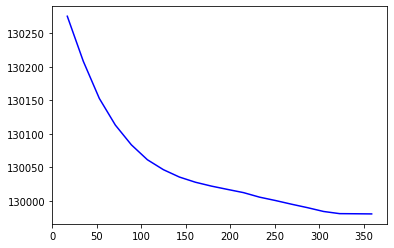

In [149]:
plt.plot(steps,mses,'b')

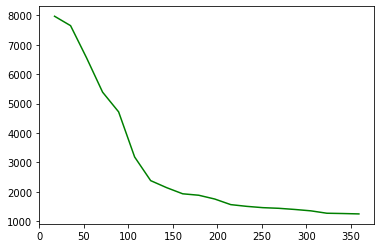

In [150]:
plt.plot(steps,regrets,'g')

In [151]:
listwise_result = trainer.test(listwise_model, dataloaders=test_dl)
listwise_result_df = pd.DataFrame(listwise_result)
listwise_result_df['model'] = 'Listwise'

/home/jayanta/anaconda3/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Testing: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_mse': 147463.59375,
 'test_mse_epoch': 147463.59375,
 'test_regret': 1174.1475830078125,
 'test_regret_epoch': 1174.1475830078125}
--------------------------------------------------------------------------------


In [152]:
log_dir = "lightning_logs/Pairwise/"
shutil.rmtree(log_dir,ignore_errors=True)

In [153]:
tb_logger = pl_loggers.TensorBoardLogger(save_dir= log_dir, version=0)
trainer = pl.Trainer(max_epochs= 20, min_epochs=5, logger=tb_logger)
pairwise_model = CachingPO(loss_fn= pairwise_loss,init_cache=init_cache, net=nn.Linear(8,1),tau=0.1, lr= 0.05, max_epochs= 30)
trainer.fit(pairwise_model , train_dl, valid_dl)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 10

  | Name | Type   | Params
--------------------------------
0 | net  | Linear | 9     
--------------------------------
9         Trainable params
0         Non-trainable params
9         Total params
0.000     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Global seed set to 10


Training: -1it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [154]:
parent_dir=   log_dir+"default/"
version_dirs = [os.path.join(parent_dir,v) for v in os.listdir(parent_dir)]

walltimes = []
steps = []
regrets= []
mses = []
for logs in version_dirs:
    event_accumulator = EventAccumulator(logs)
    event_accumulator.Reload()

    events = event_accumulator.Scalars("val_regret_epoch")
    walltimes.extend( [x.wall_time for x in events])
    steps.extend([x.step for x in events])
    regrets.extend([x.value for x in events])
    events = event_accumulator.Scalars("val_mse_epoch")
    mses.extend([x.value for x in events])
pairwise_lr = pd.DataFrame({"step": steps,'wall_time':walltimes,  "val_regret": regrets,
 "val_mse": mses })
pairwise_lr ['model'] ='Pairwise'

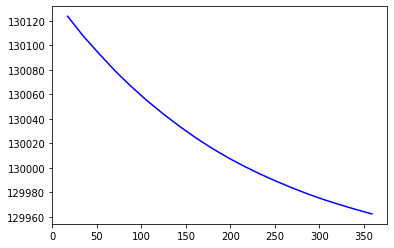

In [155]:
plt.plot(steps,mses,'b')

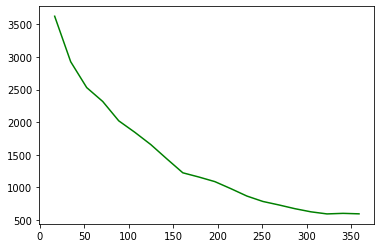

In [156]:
plt.plot(steps,regrets,'g')

In [157]:
pairwise_result = trainer.test(pairwise_model, dataloaders=test_dl)
pairwise_result_df = pd.DataFrame(pairwise_result)
pairwise_result_df['model'] = 'Pairwise'

Testing: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_mse': 147467.234375,
 'test_mse_epoch': 147467.234375,
 'test_regret': 714.9135131835938,
 'test_regret_epoch': 714.9135131835938}
--------------------------------------------------------------------------------


In [158]:
rslt_df=  pd.concat([mse_result_df,spo_result_df,listwise_result_df, pairwise_result_df],ignore_index=True)
rslt_df

,test_mse,test_mse_epoch,test_regret,test_regret_epoch,model
0,145508.640625,145508.640625,1312.559326,1312.559326,mse
1,145436.609375,145436.609375,1267.338135,1267.338135,SPO
2,147463.593750,147463.593750,1174.147583,1174.147583,Listwise
3,147467.234375,147467.234375,714.913513,714.913513,Pairwise


In [173]:
print("Per epcoh training time for MSE {:.1f}, SPO {:.1f}, Listwise {:.1f}, Pairwise {:.1f}".format(mse_lr.wall_time.diff().mean(), spo_lr.wall_time.diff().mean(),
                pairwise_lr.wall_time.diff().mean(), listwise_lr.wall_time.diff().mean()))

Per epcoh training time for MSE 1.0, SPO 15.0, Listwise 2.6, Pairwise 2.1
